In [31]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from os.path import join
import glob
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


# ===== Helper Functions ======

# Function to calculate regression line
def regression_line(x, slope, intercept):
  return slope * x + intercept

# Function to plot metrics
def plot_metric(
    df,
    x_col,
    metric="rt",          # "rt", "log_rt", or "accuracy"
    per_participant=False,
    ci=True,
    loess=False,
    loess_frac=0.3,
    ylim=None
):
    """
    Plot mean metric per block/sequence with error bars (no lines).
    """

    df = df.copy()
    df[x_col] = pd.to_numeric(df[x_col], errors="coerce")
    df = df.dropna(subset=[x_col, metric])

    plt.figure(figsize=(8, 5))

    sns.pointplot(
        data=df,
        x=x_col,
        y=metric,
        errorbar='se',
        linestyles='none',     # <-- no connecting lines
        capsize=0.05,   # small caps on error bars
        color="black"
    )

    plt.xlabel(x_col.capitalize())
    plt.ylabel(metric.replace("_", " ").capitalize())
    plt.title(f"{metric.replace('_', ' ').capitalize()} by {x_col.capitalize()}")

    if ylim:
        plt.ylim(ylim)

    plt.tight_layout()
    plt.show()

## Load data

In [32]:
import pandas as pd
import glob

# Load all CSV files from Data folder
csv_files = glob.glob('Data/data_*.csv')
dfs = []
for file in csv_files:
    df_temp = pd.read_csv(file, sep=',', header=0)
    dfs.append(df_temp)

# Combine participant dataframes
raw_srtt_df = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(csv_files)} files with {len(raw_srtt_df)} total rows")
print("\nDataframe shape:", raw_srtt_df.shape)
print("\nFirst few rows:")
print(raw_srtt_df.head(10))
print("\nDataframe info:")
print(raw_srtt_df.info())
print("\nDataframe statistics:")
print(raw_srtt_df.describe())

# Load questionnaire data
questionnaire_df = pd.read_excel('Questionnaires.xlsx')

Loaded 23 files with 8878 total rows

Dataframe shape: (8878, 9)

First few rows:
   participant block  trial  stim_pos correct_key response  \
0            1     1    1.0       1.0           s        s   
1            1     1    2.0       2.0           d        d   
2            1     1    3.0       1.0           s        s   
3            1     1    4.0       2.0           d        d   
4            1     1    5.0       3.0           f        f   
5            1     1    6.0       2.0           d        d   
6            1     1    7.0       0.0           a        a   
7            1     1    8.0       1.0           s        s   
8            1     1    9.0       1.0           s        s   
9            1     1   10.0       2.0           d        d   

                    rt  accuracy  score  
0   0.7586459999438375       1.0  127.0  
1  0.48282269993796945       1.0  142.0  
2   0.3808769000461325       1.0  158.0  
3   0.3781413999386132       1.0  174.0  
4  0.48709640000015497   

## Data anonymization

In [33]:
# Create mapping from original participant IDs to anonymized IDs
unique_participants = sorted(raw_srtt_df['participant'].unique())
participant_mapping = pd.DataFrame({
    'original_id': unique_participants,
    'anonymized_id': [f'{i:03d}' for i in range(1, len(unique_participants) + 1)]
})

# Save the mapping (keep this secure - do not share with data!)
participant_mapping.to_csv('participant_id_mapping.csv', index=False)
print("Participant ID mapping saved to 'participant_id_mapping.csv'")

# Create anonymized SRTT data
raw_srtt_df_anon = raw_srtt_df.copy()
raw_srtt_df_anon = raw_srtt_df_anon.merge(participant_mapping, left_on='participant', right_on='original_id', how='left')
raw_srtt_df_anon['participant'] = raw_srtt_df_anon['anonymized_id']
raw_srtt_df_anon = raw_srtt_df_anon.drop(['original_id', 'anonymized_id'], axis=1)

# Save anonymized SRTT data
raw_srtt_df_anon.to_csv('srtt_data_anonymized.csv', index=False)
print(f"\nAnonymized SRTT data saved to 'srtt_data_anonymized.csv'")
print(f"Shape: {raw_srtt_df_anon.shape}")

# Anonymize questionnaire data
questionnaire_df_anon = questionnaire_df.copy()
questionnaire_df_anon = questionnaire_df_anon.merge(participant_mapping, left_on='participant', right_on='original_id', how='left')
questionnaire_df_anon['participant'] = questionnaire_df_anon['anonymized_id']
questionnaire_df_anon = questionnaire_df_anon.drop(['original_id', 'anonymized_id'], axis=1)

# Save anonymized questionnaire data
questionnaire_df_anon.to_csv('questionnaires_anonymized.csv', index=False)
print(f"Anonymized questionnaire data saved to 'questionnaires_anonymized.csv'")
print(f"Shape: {questionnaire_df_anon.shape}")

Participant ID mapping saved to 'participant_id_mapping.csv'

Anonymized SRTT data saved to 'srtt_data_anonymized.csv'
Shape: (8878, 9)
Anonymized questionnaire data saved to 'questionnaires_anonymized.csv'
Shape: (23, 16)


## Data preprocessing

In [34]:
raw_df = raw_srtt_df_anon.copy()
questionnaire_df = questionnaire_df_anon.copy()
merged_df = raw_srtt_df_anon.merge(questionnaire_df_anon, on='participant', how='left')

# Data type conversions
merged_df['rt'] = pd.to_numeric(merged_df['rt'], errors='coerce')  # Convert rt to numeric
merged_df['block'] = pd.to_numeric(merged_df['block'], errors='coerce')  # Convert block to numeric
merged_df['accuracy'] = pd.to_numeric(merged_df['accuracy'], errors='coerce')  # Convert accuracy to numeric

# Create sequence column: 0 for blocks without sequence (1, 6, 7), sequence number for blocks with sequence (2-5, 8)
merged_df['sequence'] = 0
sequence_blocks = [2, 3, 4, 5]
merged_df.loc[merged_df['block'].isin(sequence_blocks), 'sequence'] = (merged_df.loc[merged_df['block'].isin(sequence_blocks), 'trial']-1) // 12 + (merged_df['block']-2)*4
merged_df.loc[merged_df['block'] == 8, 'sequence'] = (merged_df.loc[merged_df['block'] == 8, 'trial']-1) // 12

public_df = merged_df.copy()
public_df.to_csv('public_srtt_dataframe.csv', index=False)

# Clean up data
merged_df = merged_df.dropna(subset=['rt', 'accuracy', 'block', 'trial'])  # Drop rows with NaN in key columns
merged_df = merged_df[(merged_df['rt'] >= 0.1) & (merged_df['rt'] <= 1)]  # Keep only rows with valid rt
merged_df = merged_df[merged_df['L'] < 0.66] # Exclude participants with L >= 0.66
print(f"Excluded participants with L >= 0.66. Remaining: {merged_df['participant'].nunique()} participants")
merged_df = merged_df.drop(columns=['L'])  # Drop L and accuracy columns if present
merged_df.head()

# Filter data for sequence blocks only
df = merged_df[merged_df['block'].isin([2,3,4,5])]

# Remap block values: 2->1, 3->2, 4->3, 5->4
df['block'] = df['block'].map({2: 1, 3: 2, 4: 3, 5: 4})


Excluded participants with L >= 0.66. Remaining: 21 participants


C:\Users\modla\AppData\Local\Temp\ipykernel_5996\1642597191.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['block'] = df['block'].map({2: 1, 3: 2, 4: 3, 5: 4})


## Analysis of accuracy

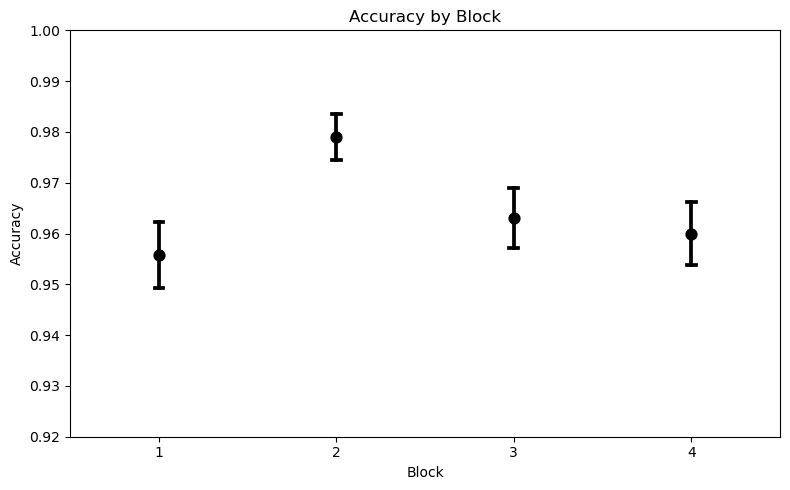

In [35]:
trials = df['trial'].values
accuracies = df['accuracy'].values
blocks = df['block'].values

avg_accuracies_block = df.groupby('block')['accuracy'].mean().values
plot_metric(df, x_col="block", metric="accuracy", per_participant=False, ci=True, ylim=(0.92, 1))

C:\Users\modla\AppData\Local\Temp\ipykernel_5996\3240736351.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_rt'] = np.log(df['rt'])


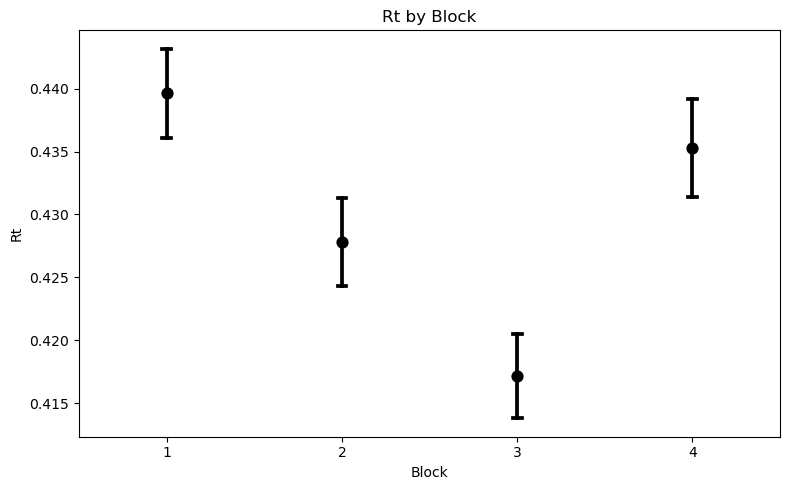

<Figure size 640x480 with 0 Axes>

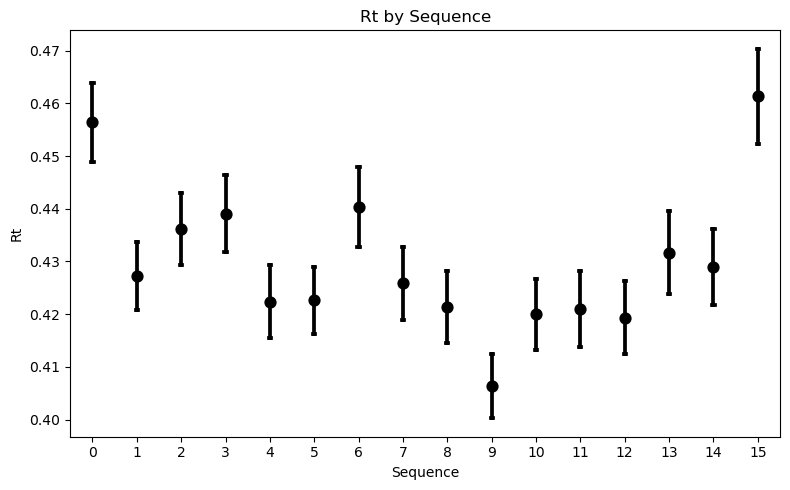

<Figure size 640x480 with 0 Axes>


Before filtering incorrect trials: 3998 rows
After filtering incorrect trials: 3856 rows
Mixed-Effects Model Results for Sequence Blocks:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: rt       
No. Observations: 3856    Method:             REML     
No. Groups:       21      Scale:              0.0100   
Min. group size:  161     Log-Likelihood:     3352.7495
Max. group size:  191     Converged:          Yes      
Mean group size:  183.6                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.437    0.012 36.849 0.000  0.414  0.461
block        -0.002    0.001 -1.582 0.114 -0.005  0.001
Group Var     0.003    0.008                           



c:\Users\modla\miniconda3\envs\srtt\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


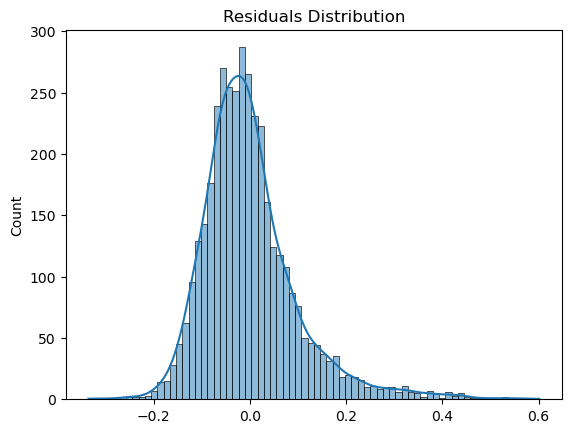

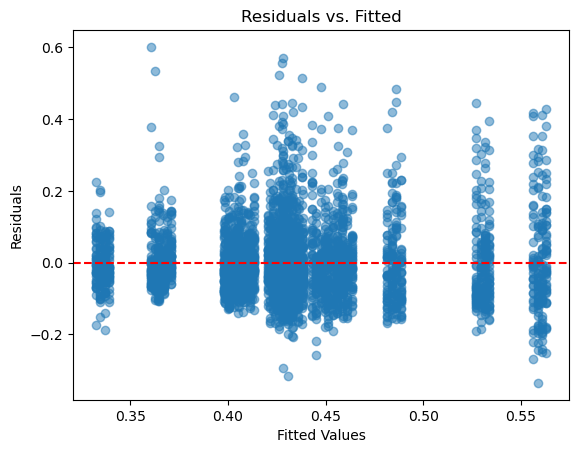

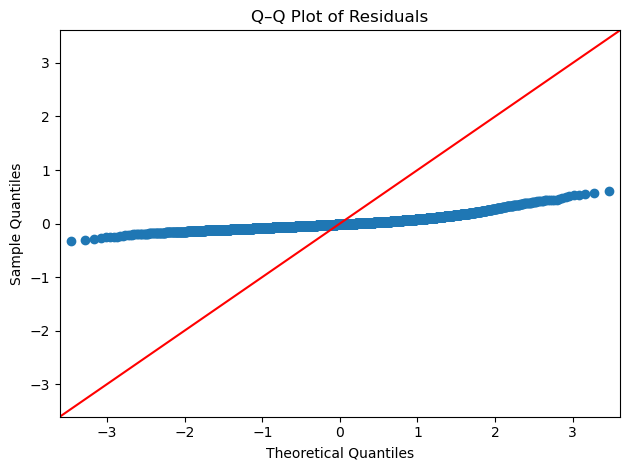

Mixed-Effects Model Results for Sequence Blocks (Log Transformed RT):
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.log(rt)
No. Observations: 3856    Method:             REML      
No. Groups:       21      Scale:              0.0448    
Min. group size:  161     Log-Likelihood:     469.6619  
Max. group size:  191     Converged:          Yes       
Mean group size:  183.6                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    -0.851    0.026 -32.651 0.000 -0.902 -0.800
block        -0.008    0.003  -2.495 0.013 -0.014 -0.002
Group Var     0.013    0.020                            



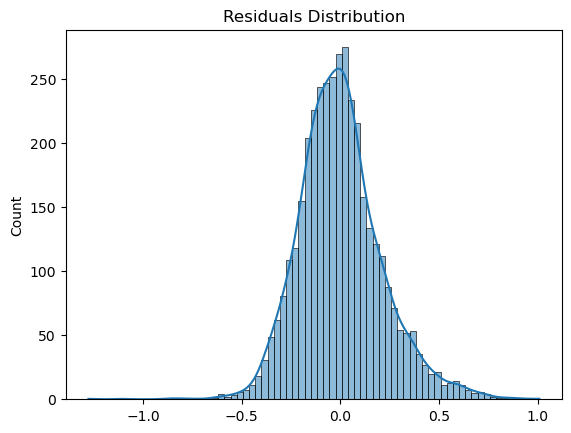

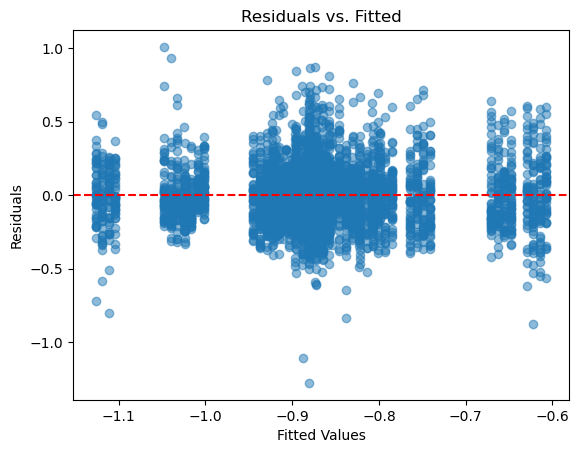

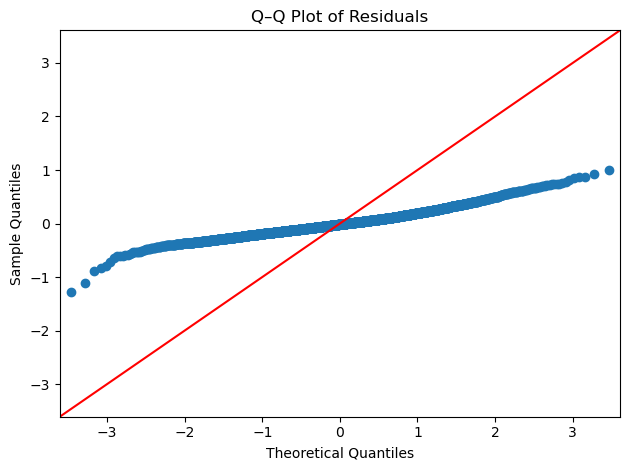

C:\Users\modla\AppData\Local\Temp\ipykernel_5996\3240736351.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(
C:\Users\modla\AppData\Local\Temp\ipykernel_5996\3240736351.py:83: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


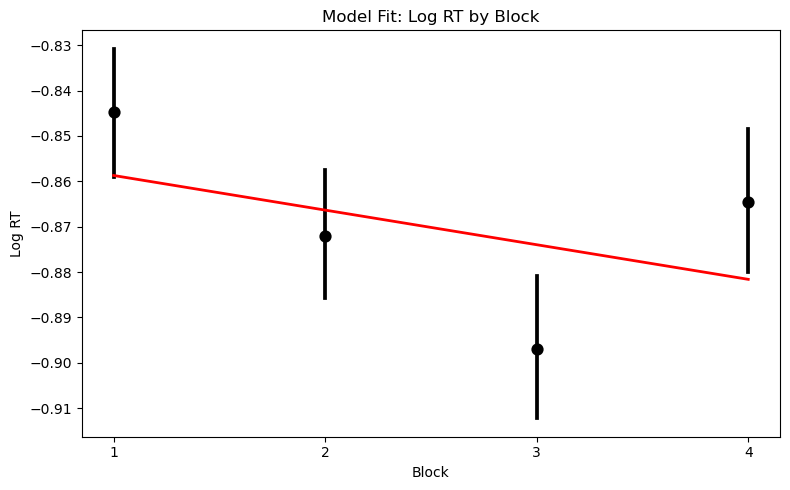

In [36]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Calculate RT averages per block
rts = pd.to_numeric(df['rt'].values, errors='coerce')
block_nums = np.unique(pd.to_numeric(blocks, errors='coerce'))
blocks_numeric = pd.to_numeric(blocks, errors='coerce')

df['log_rt'] = np.log(df['rt'])

plot_metric(df, x_col="block", metric="rt")

plt.tight_layout()
plt.show()

# Calculate averages per sequence
sequence_nums = np.unique(pd.to_numeric(df['sequence'], errors='coerce'))
avg_rts_sequence = [rts[df['sequence'] == s].mean() for s in sequence_nums]

slope_seq, intercept_seq, r_seq, p_seq, std_err_seq = stats.linregress(sequence_nums, np.array(avg_rts_sequence))

plot_metric(df, 'sequence', metric='rt', per_participant=True, ci=True)
plt.tight_layout()
plt.show()

# Remove trials where participants pressed incorrect keys
print(f"\nBefore filtering incorrect trials: {len(df)} rows")
df = df[df['accuracy'] == 1]  # Keep only correct trials
print(f"After filtering incorrect trials: {len(df)} rows")

def check_model_assumptions(model):
  residuals = model.resid
  fitted = model.fittedvalues

  # Histogram of residuals
  sns.histplot(residuals, kde=True)
  plt.title("Residuals Distribution")
  plt.show()

  # Residuals vs. Fitted
  plt.scatter(fitted, residuals, alpha=0.5)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel("Fitted Values")
  plt.ylabel("Residuals")
  plt.title("Residuals vs. Fitted")
  plt.show()

  # Q-Q plot of residuals
  sm.qqplot(residuals, line='45')
  plt.title("Q–Q Plot of Residuals")
  plt.tight_layout()
  plt.show()

# Analyse reaction times with mixed-effects model
# Mixed-effects model (for sequence blocks only)
model = smf.mixedlm("rt ~ block", df, groups=df["participant"]).fit()
print("Mixed-Effects Model Results for Sequence Blocks:")
print(model.summary())
check_model_assumptions(model)

# Mixed-effects model for sequence blocks log transformed RT
model_log = smf.mixedlm("np.log(rt) ~ block", df, groups=df["participant"]).fit()
print("Mixed-Effects Model Results for Sequence Blocks (Log Transformed RT):")
print(model_log.summary())
check_model_assumptions(model_log)

#It seems like the significance improved with log transformation and residuals look better too.

# Extract fixed effects
intercept = model_log.params["Intercept"]
slope = model_log.params["block"]

# Prepare x-values
x_vals = sorted(df["block"].unique())
y_pred = intercept + slope * np.array(x_vals)

# Plot
plt.figure(figsize=(8,5))

# Dots with error bars
sns.pointplot(
    data=df,
    x="block",
    y="log_rt",
    ci=95,
    join=False,
    color="black"
)

# Regression line - map block values to plot indices
x_indices = np.arange(len(x_vals))
plt.plot(x_indices, y_pred, color="red", linewidth=2)

plt.xlabel("Block")
plt.ylabel("Log RT")
plt.title("Model Fit: Log RT by Block")
plt.tight_layout()
plt.show()

## Analysis of traits
### Set up analysis and analyze correlations


Participant-level summary with traits:
  participant    log_rt  accuracy  Instrument  Piano_Keyboard  \
0         001 -0.869365       1.0        True           False   
1         002 -0.874014       1.0        True           False   
2         003 -0.750228       1.0        True           False   
3         004 -0.809361       1.0        True            True   
4         005 -0.868116       1.0       False           False   

   Sports_training  Gamer  Gender  Age  act  agghost     impss  neuranx  soc  \
0             True  False  Female   22  0.2      0.6  0.500000      1.0  0.1   
1             True  False  Female   20  0.5      0.3  0.400000      0.7  0.0   
2            False   True  Female   20  0.2      0.6  0.500000      0.9  0.8   
3             True  False  Female   26  0.8      0.4  0.400000      0.6  0.4   
4             True   True  Female   20  0.0      0.1  0.333333      1.0  0.3   

          N         P         E         L  
0  0.833333  0.250000  0.416667  0.166667  


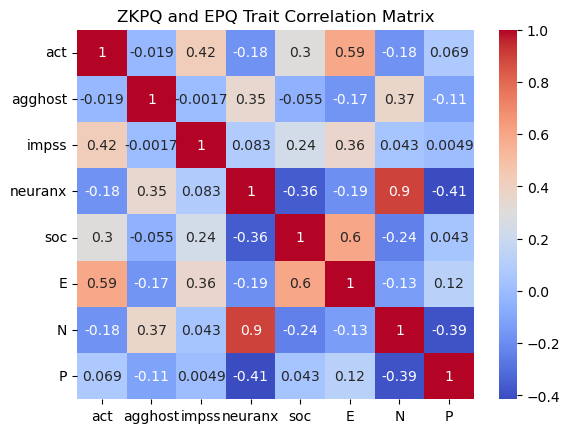

In [37]:
summary_df = df.groupby("participant").agg({
    "log_rt": "mean",
    "accuracy": "mean",
    # Add trait columns from questionnaire_df
}).reset_index()

# Merge with traits
summary_df = summary_df.merge(questionnaire_df, on="participant", how="left")
print("\nParticipant-level summary with traits:")
print(summary_df.head())

# Analyze correlations between tests
zkpq_trait_cols = ['act', 'agghost', 'impss', 'neuranx', 'soc']
epq_trait_cols = ['E', 'N', 'P']
trait_cols = zkpq_trait_cols + epq_trait_cols
correlation_matrix_all = summary_df[trait_cols].corr()
print("\nCorrelation matrix between ZKPQ and EPQ traits:")
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm')
plt.title("ZKPQ and EPQ Trait Correlation Matrix")
plt.show()

### Analysis of EPQ traits


Correlation matrix within EPQ traits:


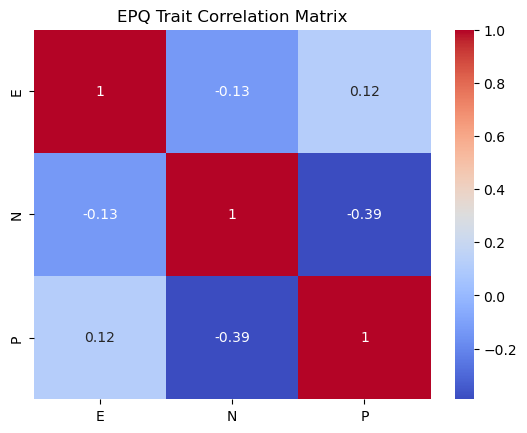


Model with EPQ Traits:
                            OLS Regression Results                            
Dep. Variable:                 log_rt   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     1.610
Date:                 V, 04 jan. 2026   Prob (F-statistic):              0.224
Time:                        23:21:53   Log-Likelihood:                 18.881
No. Observations:                  21   AIC:                            -29.76
Df Residuals:                      17   BIC:                            -25.58
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9921      0

In [38]:
import statsmodels.formula.api as smf

# Analyze EPQ traits correlations
correlation_matrix_epq = summary_df[epq_trait_cols].corr()
print("\nCorrelation matrix within EPQ traits:")
sns.heatmap(correlation_matrix_epq, annot=True, cmap='coolwarm')
plt.title("EPQ Trait Correlation Matrix")
plt.show()

# Fit model with epq traits as predictors for reaction time
model_rt_epq = smf.ols("log_rt ~ E + P + N", data=summary_df).fit()
print("\nModel with EPQ Traits:")
print(model_rt_epq.summary())

# Fit model with epq traits as predictors for learning rate
model_learning_rate_epq = smf.mixedlm("log_rt ~ block * (E + P + N)", df, groups=df["participant"]).fit()
print("\nMixed-Effects Model for Learning Rate with Traits:")
print(model_learning_rate_epq.summary())

# Fit model with epq traits as predictors for learning curve
model_learning_curve_epq = smf.mixedlm(
    "log_rt ~ bs(block, df=3) * (E + P + N)",
    df,
    groups=df["participant"]
).fit()
print("\nMixed-Effects Model for Learning Rate with EPQ Traits:")
print(model_learning_curve_epq.summary())

#### Neuroticism effect on mean of log reaction time

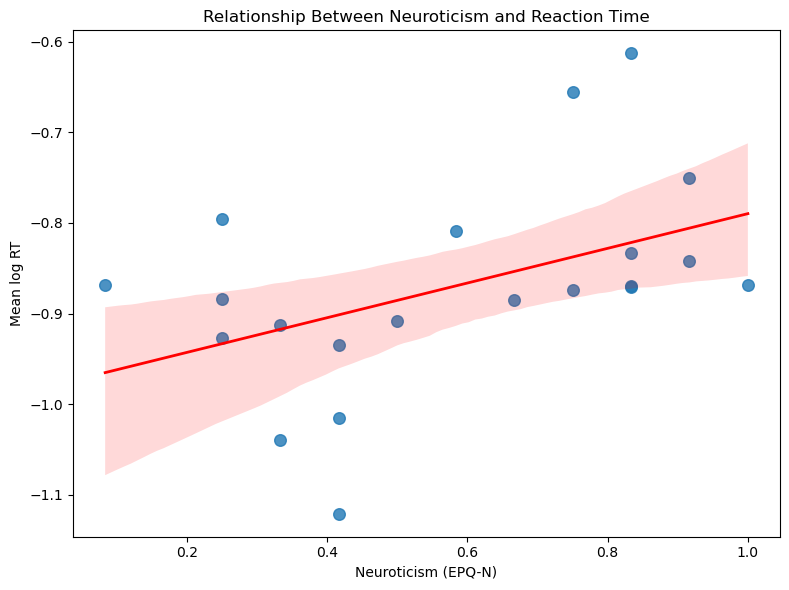

In [39]:
# Nueroticism vs mean log RT
plt.figure(figsize=(8, 6))

sns.regplot(
    data=summary_df,
    x="N",
    y="log_rt",
    scatter_kws={"s": 70, "alpha": 0.8},
    line_kws={"color": "red", "linewidth": 2}
)

plt.xlabel("Neuroticism (EPQ-N)")
plt.ylabel("Mean log RT")
plt.title("Relationship Between Neuroticism and Reaction Time")
plt.tight_layout()
plt.show()

#### Extraversion, Psychoticism and Neuroticism effects on learning rate

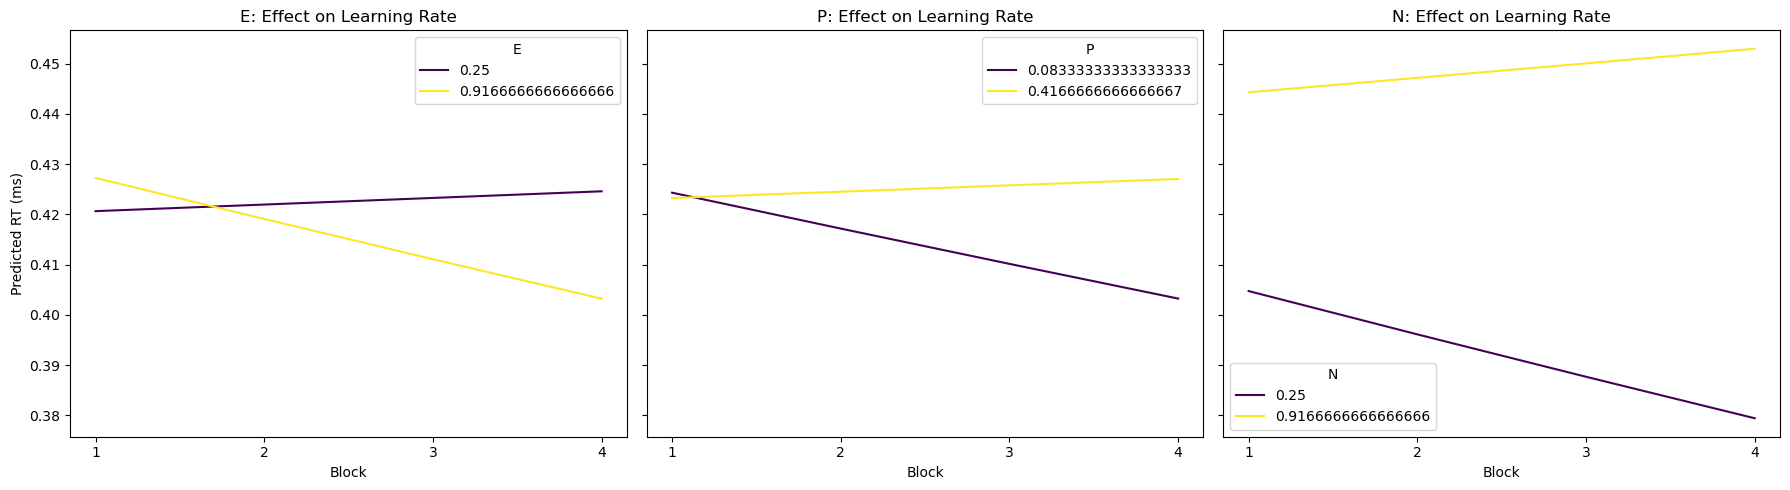

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

traits = ["E", "P", "N"]
blocks = sorted(df["block"].unique())

percentiles = summary_df[traits].quantile([0.1, 0.9])
low_vals = percentiles.loc[0.1]
high_vals = percentiles.loc[0.9]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, trait in zip(axes, traits):

    pred_df = pd.DataFrame({
        "block": np.tile(blocks, 2),
        "participant": 0
    })

    # Add all traits at their mean
    for col in traits:
        pred_df[col] = summary_df[col].mean()

    # Set low/high values for the focal trait
    pred_df[trait] = np.repeat([low_vals[trait], high_vals[trait]], len(blocks))

    # Predict log RT
    pred_df["pred_log"] = model_learning_rate_epq.predict(pred_df)

    # Convert to actual RT
    pred_df["pred_rt"] = np.exp(pred_df["pred_log"])

    # Plot
    sns.lineplot(
        data=pred_df,
        x="block",
        y="pred_rt",
        hue=trait,
        palette="viridis",
        ax=ax
    )

    # Fix x-axis to show only whole blocks
    ax.set_xticks(blocks)

    ax.set_title(f"{trait}: Effect on Learning Rate")
    ax.set_xlabel("Block")
    ax.set_ylabel("Predicted RT (ms)")

plt.tight_layout()
plt.show()

#### Extraversion, Psychoticism and Neuroticism effect on learning curve

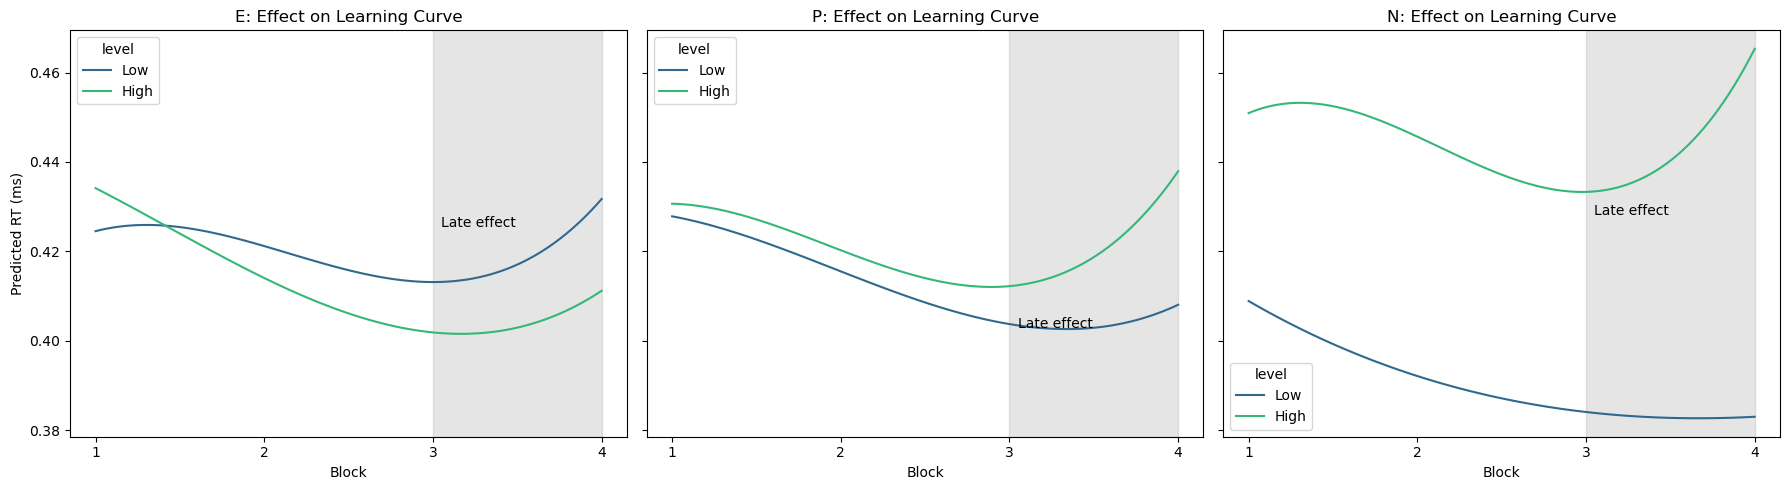

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

traits = ["E", "P", "N"]
blocks = sorted(df["block"].unique())
blocks_fine = np.linspace(min(blocks), max(blocks), 100)

# Low/high trait values (10th and 90th percentiles)
percentiles = summary_df[traits].quantile([0.1, 0.9])
low_vals = percentiles.loc[0.1]
high_vals = percentiles.loc[0.9]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, trait in zip(axes, traits):

    pred_df = pd.DataFrame({
        "block": np.tile(blocks_fine, 2),
        "participant": 0
    })

    # Set all traits to mean
    for col in ["E", "P", "N"]:
        pred_df[col] = summary_df[col].mean()

    # Assign low/high values
    pred_df[trait] = np.repeat([low_vals[trait], high_vals[trait]], len(blocks_fine))

    # Add a categorical label for plotting
    pred_df["level"] = np.repeat(["Low", "High"], len(blocks_fine))

    pred_df["pred_log"] = model_learning_curve_epq.predict(pred_df)
    pred_df["pred_rt"] = np.exp(pred_df["pred_log"])

    sns.lineplot(
        data=pred_df,
        x="block",
        y="pred_rt",
        hue="level",
        palette="viridis",
        ax=ax,
        estimator=None,
        sort=True
    )

    # ---------------------------
    # ANNOTATIONS
    # ---------------------------

    if trait == "E":
        ax.axvspan(3, 4, color="gray", alpha=0.2)
        ax.text(3.05, pred_df["pred_rt"].max()*0.98, "Late effect", fontsize=10)

    if trait == "P":
        ax.axvspan(3, 4, color="gray", alpha=0.2)
        ax.text(3.05, pred_df["pred_rt"].max()*0.92, "Late effect", fontsize=10)

    if trait == "N":
        ax.axvspan(3, 4, color="gray", alpha=0.2)
        ax.text(3.05, pred_df["pred_rt"].max()*0.92, "Late effect", fontsize=10)

    # ---------------------------

    ax.set_xticks(blocks)
    ax.set_title(f"{trait}: Effect on Learning Curve")
    ax.set_xlabel("Block")
    ax.set_ylabel("Predicted RT (ms)")

plt.tight_layout()
plt.show()

### Analysis of ZKPQ traits


Correlation matrix within ZKPQ traits:


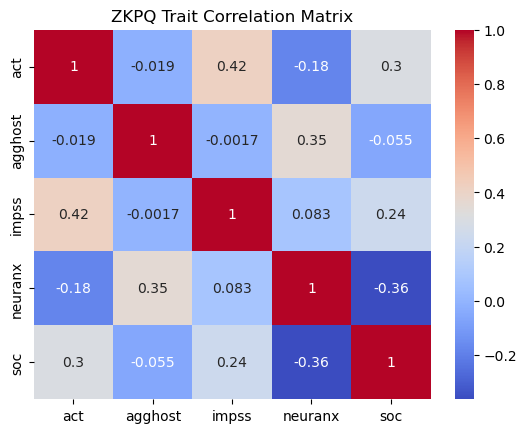


Model with ZKPQ Traits:
                            OLS Regression Results                            
Dep. Variable:                 log_rt   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9913
Date:                 V, 04 jan. 2026   Prob (F-statistic):              0.455
Time:                        23:21:55   Log-Likelihood:                 19.253
No. Observations:                  21   AIC:                            -26.51
Df Residuals:                      15   BIC:                            -20.24
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9977      

In [42]:
import statsmodels.formula.api as smf

# Analyze correlations within ZKPQ traits
correlation_matrix_zkpq = summary_df[zkpq_trait_cols].corr()
print("\nCorrelation matrix within ZKPQ traits:")
sns.heatmap(correlation_matrix_zkpq, annot=True, cmap='coolwarm')
plt.title("ZKPQ Trait Correlation Matrix")
plt.show()

# Fit model with zkpq traits as predictors
model_rt_zkpq = smf.ols("log_rt ~ act + agghost + impss + neuranx + soc", data=summary_df).fit()
print("\nModel with ZKPQ Traits:")
print(model_rt_zkpq.summary())

# Fit model with learning rate as outcome for zkpq traits
model_learning_rate_zkpq = smf.mixedlm("log_rt ~ block * (act + agghost + impss + neuranx + soc)", df, groups=df["participant"]).fit()
print("\nMixed-Effects Model for Learning Rate with Traits:")
print(model_learning_rate_zkpq.summary())

# Fit model with zkpq traits as predictors for learning curve
model_learning_curve_zkpq = smf.mixedlm(
    "log_rt ~ bs(block, df=3) * (act + agghost + impss + neuranx + soc)",
    df,
    groups=df["participant"]
).fit()
print("\nMixed-Effects Model for Learning Rate with ZKPQ Traits:")
print(model_learning_curve_zkpq.summary())

print(summary_df[["log_rt", "neuranx"]].corr())

#### Residual analysis of models for zkpq traits


Checking model assumptions for ZKPQ trait models:
Model for RT:


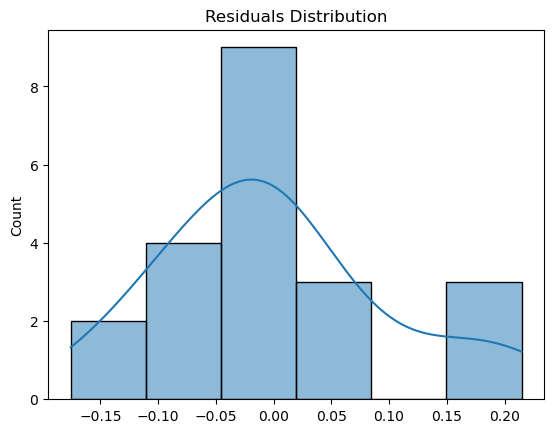

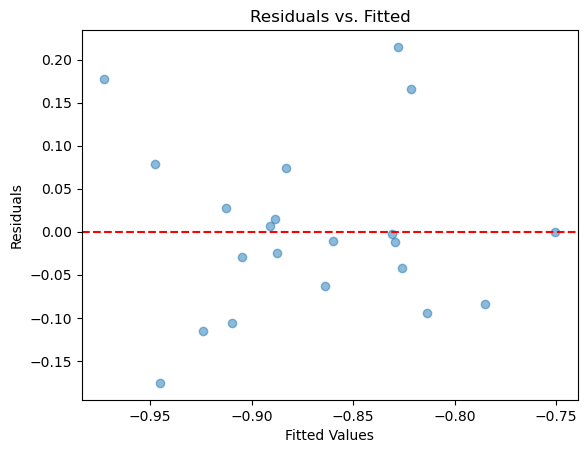

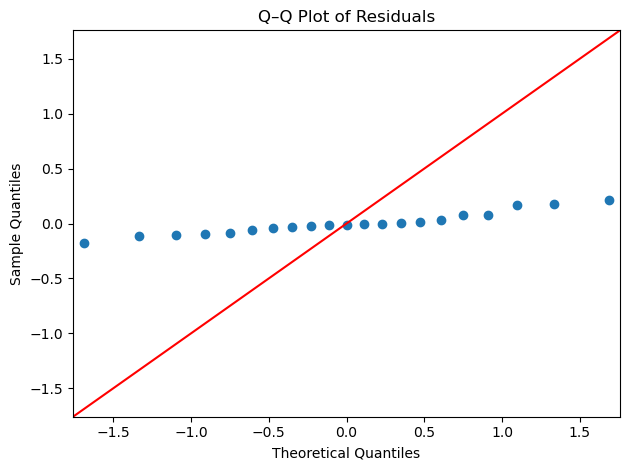

Model for Learning Rate:


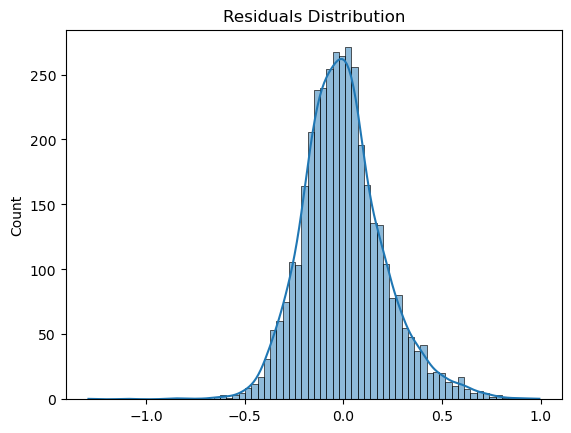

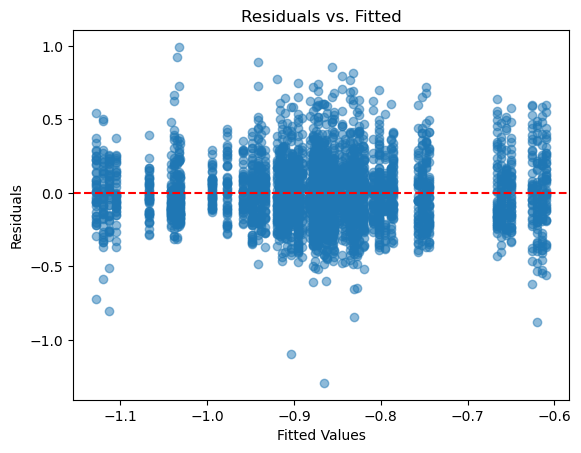

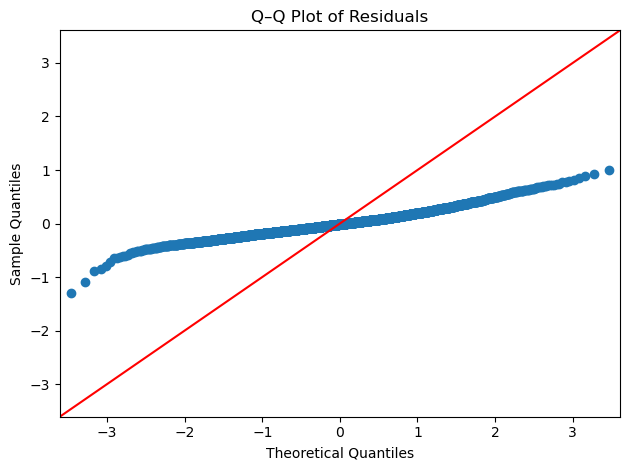

Model for Learning Curve:


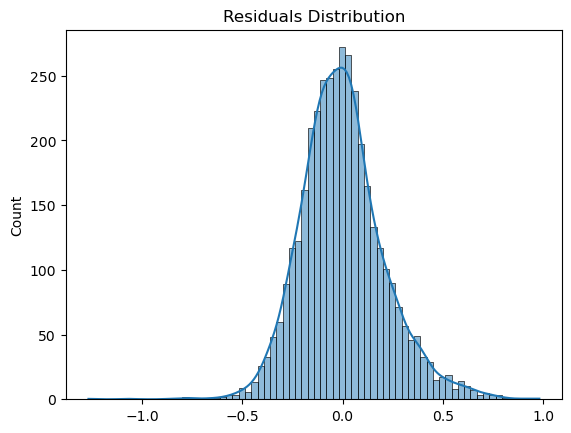

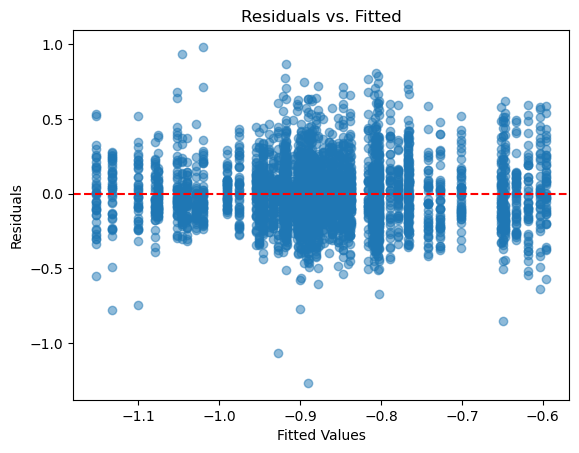

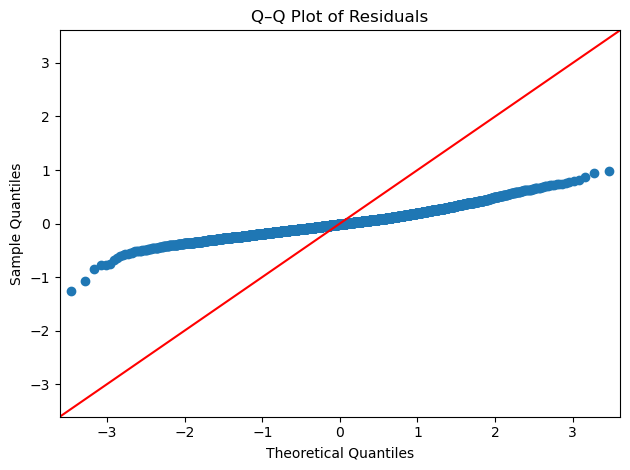

C:\Users\modla\AppData\Local\Temp\ipykernel_5996\2888049669.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  random_intercepts_zkpq = np.array([v[0] for v in random_effects_zkpq.values()])


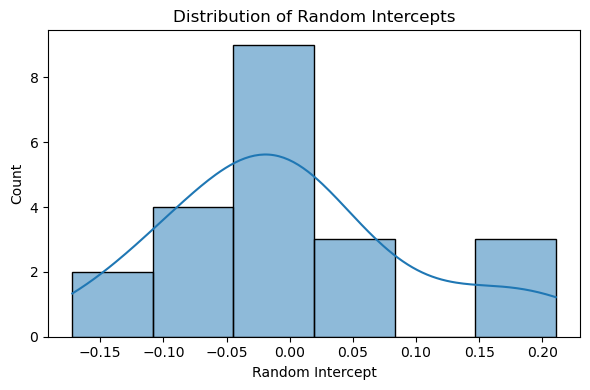

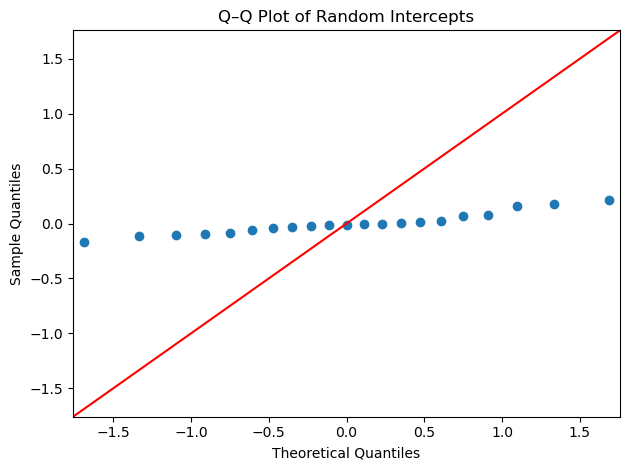

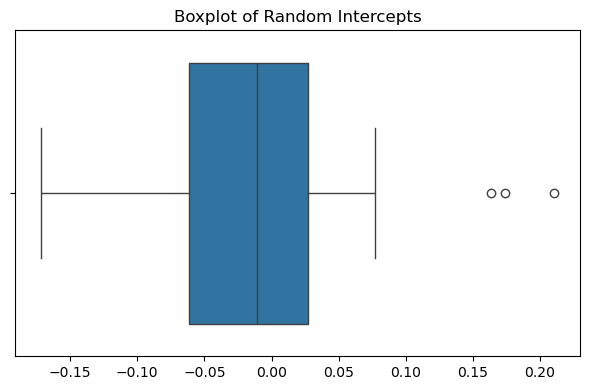

In [43]:
import statsmodels.api as sm

# Check model assumptions for ZKPQ trait models
print("\nChecking model assumptions for ZKPQ trait models:")
print("Model for RT:")
check_model_assumptions(model_rt_zkpq)
print("Model for Learning Rate:")
check_model_assumptions(model_learning_rate_zkpq)
print("Model for Learning Curve:")
check_model_assumptions(model_learning_curve_zkpq)

# Extract random effects from learning curve model
random_effects_zkpq = model_learning_curve_zkpq.random_effects
random_intercepts_zkpq = np.array([v[0] for v in random_effects_zkpq.values()])

# Histogram of random intercepts
plt.figure(figsize=(6, 4))
sns.histplot(random_intercepts_zkpq, kde=True)
plt.title("Distribution of Random Intercepts")
plt.xlabel("Random Intercept")
plt.tight_layout()
plt.show()

# Q–Q plot of random intercepts
sm.qqplot(random_intercepts_zkpq, line='45')
plt.title("Q–Q Plot of Random Intercepts")
plt.tight_layout()
plt.show()

# Boxplot of random intercepts
plt.figure(figsize=(6, 4))
sns.boxplot(x=random_intercepts_zkpq)
plt.title("Boxplot of Random Intercepts")
plt.tight_layout()
plt.show()

#### Actionability and neuroticism-anxiety effects on learning rate

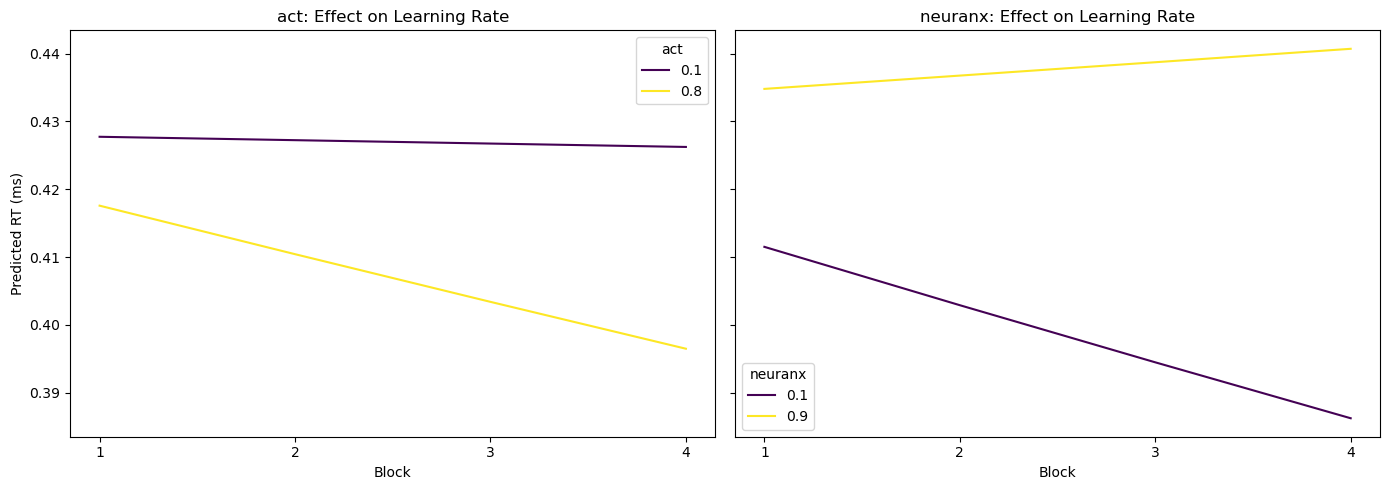

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Traits with significant learning-rate effects
traits = ["act", "neuranx"]

# Blocks
blocks = sorted(df["block"].unique())

# Low/high trait values (10th and 90th percentiles)
percentiles = summary_df[traits].quantile([0.1, 0.9])
low_vals = percentiles.loc[0.1]
high_vals = percentiles.loc[0.9]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, trait in zip(axes, traits):

    # Build prediction dataframe
    pred_df = pd.DataFrame({
        "block": np.tile(blocks, 2),
        "participant": 0  # dummy for mixed model
    })

    # Set all traits to their mean
    for col in ["act", "agghost", "impss", "neuranx", "soc"]:
        pred_df[col] = summary_df[col].mean()

    # Set low/high values for the focal trait
    pred_df[trait] = np.repeat([low_vals[trait], high_vals[trait]], len(blocks))

    # Predict log RT
    pred_df["pred_log"] = model_learning_rate_zkpq.predict(pred_df)

    # Convert to actual RT (ms)
    pred_df["pred_rt"] = np.exp(pred_df["pred_log"])

    # Plot
    sns.lineplot(
        data=pred_df,
        x="block",
        y="pred_rt",
        hue=trait,
        palette="viridis",
        ax=ax
    )

    # Force whole-number ticks on x-axis
    ax.set_xticks(blocks)

    ax.set_title(f"{trait}: Effect on Learning Rate")
    ax.set_xlabel("Block")
    ax.set_ylabel("Predicted RT (ms)")

plt.tight_layout()
plt.show()

#### Impusivity, neuroticism-anxiety and sociability effects on learning curve

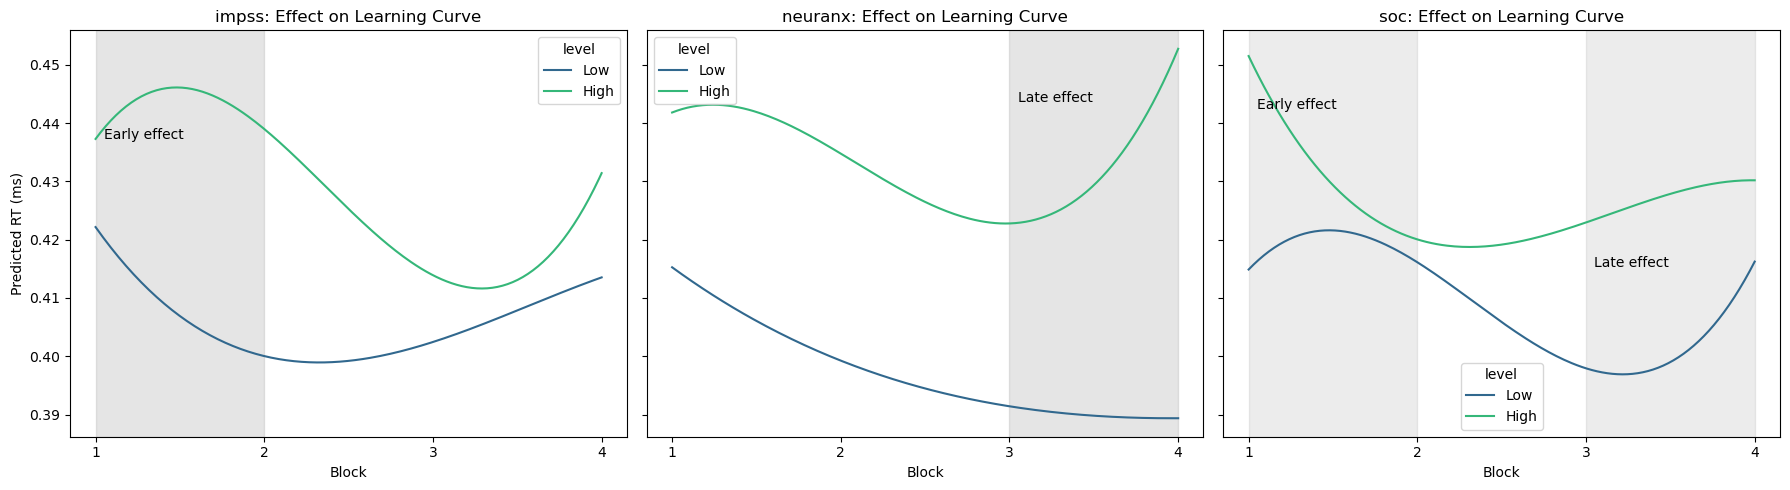

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

traits = ["impss", "neuranx", "soc"]

blocks = sorted(df["block"].unique())
blocks_fine = np.linspace(min(blocks), max(blocks), 200)

percentiles = summary_df[traits].quantile([0.1, 0.9])
low_vals = percentiles.loc[0.1]
high_vals = percentiles.loc[0.9]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, trait in zip(axes, traits):

    pred_df = pd.DataFrame({
        "block": np.tile(blocks_fine, 2),
        "participant": 0
    })

    # Set all traits to mean
    for col in ["act", "agghost", "impss", "neuranx", "soc"]:
        pred_df[col] = summary_df[col].mean()

    # Assign low/high values
    pred_df[trait] = np.repeat([low_vals[trait], high_vals[trait]], len(blocks_fine))

    # Add a categorical label for plotting
    pred_df["level"] = np.repeat(["Low", "High"], len(blocks_fine))

    pred_df["pred_log"] = model_learning_curve_zkpq.predict(pred_df)
    pred_df["pred_rt"] = np.exp(pred_df["pred_log"])

    sns.lineplot(
        data=pred_df,
        x="block",
        y="pred_rt",
        hue="level",        # <-- categorical, not numeric
        palette="viridis",
        ax=ax,
        estimator=None,
        sort=True
    )

    # ---------------------------
    # ANNOTATIONS
    # ---------------------------

    if trait == "neuranx":
        ax.axvspan(3, 4, color="gray", alpha=0.2)
        ax.text(3.05, pred_df["pred_rt"].max()*0.98, "Late effect", fontsize=10)

    if trait == "soc":
        ax.axvspan(1, 2, color="gray", alpha=0.15)
        ax.axvspan(3, 4, color="gray", alpha=0.15)
        ax.text(1.05, pred_df["pred_rt"].max()*0.98, "Early effect", fontsize=10)
        ax.text(3.05, pred_df["pred_rt"].max()*0.92, "Late effect", fontsize=10)

    if trait == "impss":
        ax.axvspan(1, 2, color="gray", alpha=0.2)
        ax.text(1.05, pred_df["pred_rt"].max()*0.98, "Early effect", fontsize=10)

    # ---------------------------

    ax.set_xticks(blocks)
    ax.set_title(f"{trait}: Effect on Learning Curve")
    ax.set_xlabel("Block")
    ax.set_ylabel("Predicted RT (ms)")

plt.tight_layout()
plt.show()